## **ICP Tutorial:**

By Derek Benham

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize as opt

(-5.562621661487507,
 6.815054891237646,
 -1.5601946752049485,
 11.387897308015901)

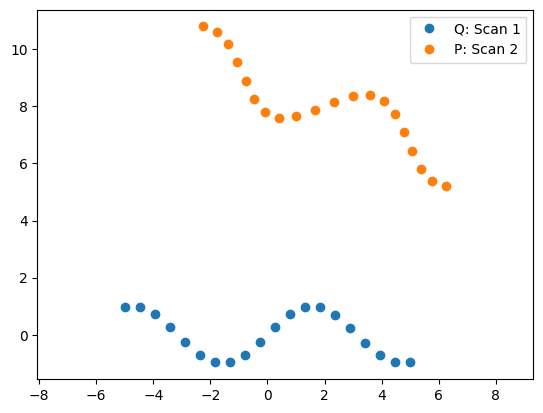

In [3]:
# Generate some data. No noise for now.
x = np.linspace(-5, 5, 20)
y = np.sin(x)
Q = np.vstack((x, y)).T

# Ground Truth Translation and Rotation matrices
theta = np.pi/8
true_rotation = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
true_translation = np.array([2, 8])

P = np.dot(Q, true_rotation) + true_translation

# plot the data
plt.plot(Q[:,0], Q[:,1], 'o', label='Q: Scan 1')
plt.plot(P[:,0], P[:,1], 'o', label='P: Scan 2')
plt.legend()
plt.axis('equal')

#### **Step 1: Find Correspondences between scans**

Our first approach for solving ICP will be the least efficient but a proof of concept. As shown in the figure below, the brute force method of finding correspondences grows at N^2

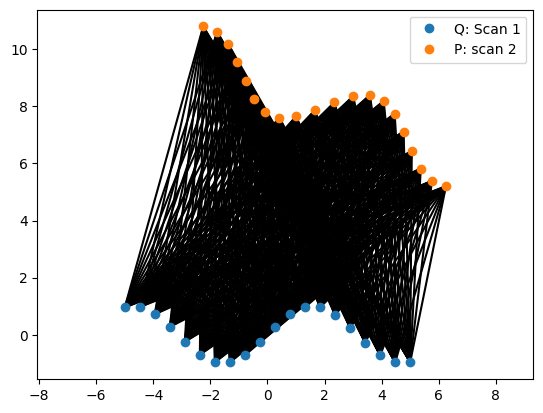

In [4]:
for i in range(Q.shape[0]):
    for j in range(P.shape[0]):
        plt.plot([Q[i,0], P[j,0]], [Q[i,1], P[j,1]], 'k-')
plt.plot(Q[:,0], Q[:,1], 'o', label='Q: Scan 1')
plt.plot(P[:,0], P[:,1], 'o', label='P: scan 2')
plt.axis('equal')
plt.legend()

Total correspondence error: 149.51


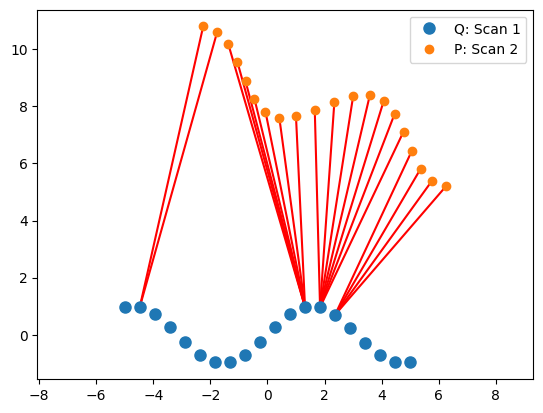

In [5]:
sum_min_correspondence_error = 0

def compute_correspondence(P, Q):
    correspondences = []
    total_dist = 0
    for i in range(P.shape[0]):
        min_dist = np.inf
        for j in range(Q.shape[0]):
            dist = np.linalg.norm(P[i] - Q[j])
            if dist < min_dist:
                min_dist = dist
                min_correspondence_idx = j
        correspondences.append(min_correspondence_idx)
        total_dist += min_dist
        
    return correspondences, total_dist

def plot_correspondence(P, Q, correspondences):
    for i in range(P.shape[0]):
        plt.plot([P[i,0], Q[correspondences[i],0]], [P[i,1], Q[correspondences[i],1]], 'r-')
    plt.plot(Q[:,0], Q[:,1], 'o', label='Q: Scan 1', markersize=8)
    plt.plot(P[:,0], P[:,1], 'o', label='P: Scan 2')
    plt.legend()
    plt.axis('equal')

correspondences, sum_error = compute_correspondence(P, Q)
plot_correspondence(P, Q, correspondences)
print("Total correspondence error:", round(sum_error, 2))

#### **Step 2: Center the 2nd Scan**

Centering the data first helps us find local minima, but also helps us find the translation error between the scans (I think)

P center: [[2. 8.]]
Total correspondence error: 19.52


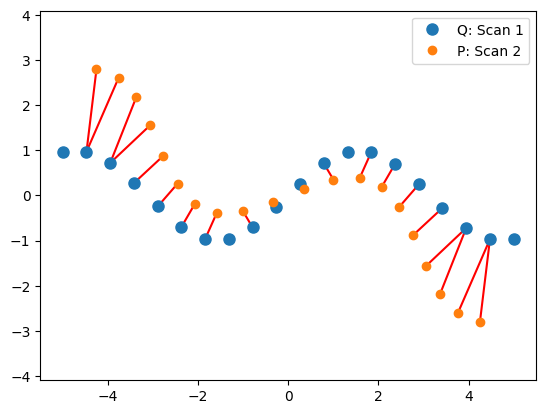

In [6]:
# Data needs to be centered for the ICP algorithm to work
def center_data(data):
    center = np.array([data.mean(axis=0)])
    return center, data - center

center_of_P, P_centered = center_data(P)

correspondences, sum_error = compute_correspondence(P_centered, Q)
plot_correspondence(P_centered, Q, correspondences)
print("P center:", center_of_P)
print("Total correspondence error:", round(sum_error, 2))

#### **Step 3: Computing the Cross Covariance**

Work in progress

$$ K_{PQ} = cov(P,Q) = \mathop{\mathbb{E}}[(P-\mu_{P})(Q-\mu_{Q})^{T} $$

$$ K_{P_{i}Q_{j}} = cov(P_{i},Q_{j}) = \mathop{\mathbb{E}}[(P_{i}-\mathop{\mathbb{E}}[P_{i}])(Q_{j}-\mathop{\mathbb{E}}[Q_{j}]) $$

Note: Because the data is centered at 0, the means are discarded

https://en.wikipedia.org/wiki/Cross-covariance

https://en.wikipedia.org/wiki/Cross-covariance_matrix

$$Inner Product = u^{T}v$$

$$Outer Product = uv^{T}$$

Inner product prudces a scaler, outer product produces a matrix


In [7]:
def compute_cross_covariance(P, Q, correspondences):
    cross_covariance = np.zeros((2,2))
    for i in range(P.shape[0]):
        cross_covariance += np.outer(P[i], Q[correspondences[i]])
    return cross_covariance

cross_covariance = compute_cross_covariance(P_centered, Q, correspondences)
print("Cross covariance matrix:\n", cross_covariance)

Cross covariance matrix:
 [[172.99853708 -17.62309375]
 [-82.5301859   17.85371624]]


With the Cross-Covariance, we will compute its SVD decomposition

$$ SVD(K) = USV^{T}$$

With these equations, the following will be calculated:

$$ R = UV^T $$
$$ t = \mu_{Q}-R\mu_{P} $$

In [8]:
def SVD(Q, P, cross_covariance):
    U, S, V = np.linalg.svd(cross_covariance)
    R = np.dot(U, V.T) 
    center_of_Q = center_data(Q)[0]
    t = (center_of_Q.T - R.T@center_of_P.T).T[0] 
    # R is transposed because indices are flipped col, row
    return R, t

R, t = SVD(Q, center_of_P, cross_covariance)
print("Rotation matrix:\n", R)
print("Translation vector:\n", t)

Rotation matrix:
 [[ 0.94674655  0.32197977]
 [-0.32197977  0.94674655]]
Translation vector:
 [ 0.6823451  -8.21793193]


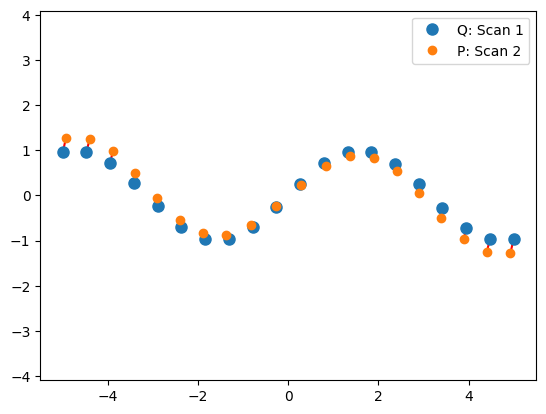

In [9]:
P_adjusted = P@R+t
correspondences, sum_error = compute_correspondence(P_adjusted, Q)
plot_correspondence(P_adjusted, Q, correspondences)

#### **Final Step: Iterative Approach**

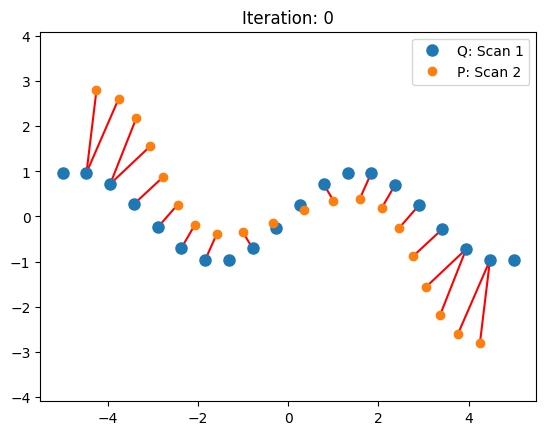

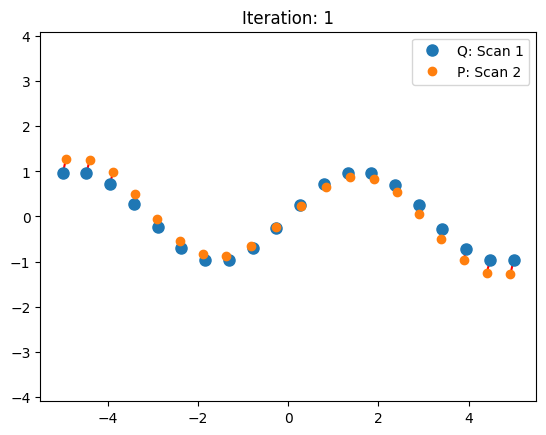

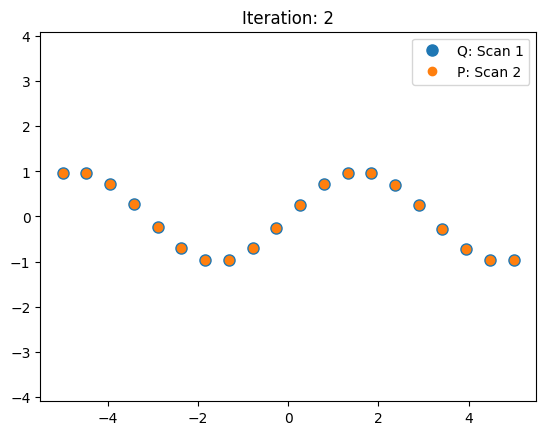

Rotation matrix:
 [[ 1.00000000e+00 -4.00269303e-18]
 [ 9.87509477e-18  1.00000000e+00]]
Translation vector:
 [-2. -8.]
Rotation Matrix Error: 0.5517987585658861
Translation Vector Error: 4.440892098500626e-16


In [10]:
def SVD_ICP(Q, P, num_iterations=10, plotting=False):
    loss = []
    center_of_P, P_centered = center_data(P)
    for i in range(num_iterations):
        correspondences, sum_error = compute_correspondence(P_centered, Q)
        if plotting:
            plot_correspondence(P_centered, Q, correspondences)
            plt.title("Iteration: " + str(i))
            plt.show()
        cross_covariance = compute_cross_covariance(P_centered, Q, correspondences)
        R, t = SVD(Q, P_centered, cross_covariance)
        P_centered = P_centered@R+t
        center_of_P, P_centered = center_data(P_centered)
        loss.append(sum_error)

    return R, t, loss

R, t, loss = SVD_ICP(Q, P, num_iterations=10, plotting=True)
print("Rotation matrix:\n", R)
print("Translation vector:\n", t)
print("Rotation Matrix Error:", np.linalg.norm(R - true_rotation))
# t is multiplied by -1 because the translation direction is flipped
print("Translation Vector Error:", np.linalg.norm(t*-1 - true_translation))


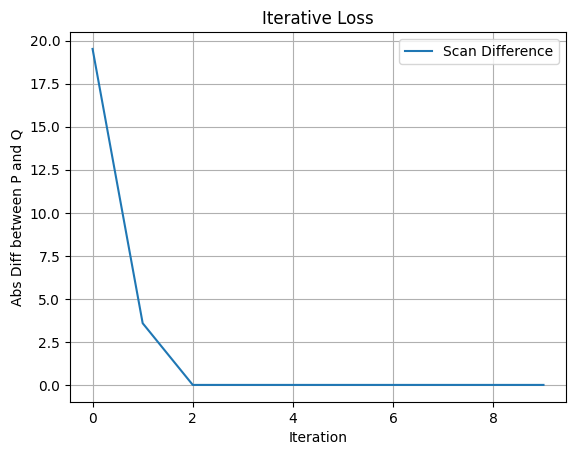

In [20]:
R, t, loss = SVD_ICP(Q, P, num_iterations=10, plotting=False)
plt.plot(loss, label='Scan Difference')
plt.grid()
plt.title("Iterative Loss")
plt.xlabel("Iteration")
plt.ylabel("Abs Diff between P and Q")
plt.legend()

## **Non-Linear Least Squares ICP**

Minimize:
$$ E = \sum_{i}[Rp_{i}+t-q_{i}]^{2} $$

Represent **x** as $[x,y,\theta]^{T}$ for which we will minimize the rotation and translation between P and Q. I will begin by solving it without the Jacobian

In [36]:
x = np.linspace(-5, 5, 20)
y = np.sin(x)
Q = np.vstack((x, y)).T

# Ground Truth Translation and Rotation matrices
theta = np.pi/8
true_rotation = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
true_translation = np.array([2, 8])

P = np.dot(Q, true_rotation) + true_translation


Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 215
         Function evaluations: 390
[ 1.21366893 -8.15640273 -0.39269317]
8.487785437350233e-09


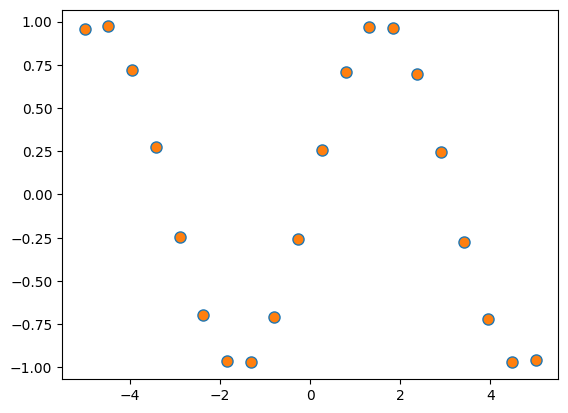

In [37]:
# correspondences, sum_error = compute_correspondence(P_adjusted, Q)

def cost(R, t):
    return np.sum(np.linalg.norm((P@R+t - Q)**2, axis=1))

def icp_least_squares(inputs):
    x = inputs[0]
    y = inputs[1]
    theta = inputs[2]
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    t = np.array([x, y])
    return cost(R, t)

x0 = [0, 0, 0]
res = opt.minimize(icp_least_squares, x0, method='Nelder-Mead', options={'disp': True})    

x = res.x[0]
y = res.x[1]
theta = res.x[2]
R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
t = np.array([x, y])

adjusted_P = P@R+t
plt.plot(Q[:,0], Q[:,1], 'o', label='Q: Scan 1', markersize=8)
plt.plot(adjusted_P[:,0], adjusted_P[:,1], 'o', label='P: Scan 2')
print(res.x)
print(res.fun)

